# AMDA termpaper: **normalizing flows**
### *by Abhinav Tyagi*
(worked together with Lennart Boehm on several parts)
---

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from astroML.datasets import fetch_rrlyrae_combined
from DataAnalysisScript import DataAnalyse
from utils.train_utils import train_density_no_tf, train_density_estimation, shuffle_split


tensorflow:  2.9.1
tensorflow-probability:  0.17.0


---
# Exercise 1 : Data visualization

In [2]:
# get data from the astroML library
X0, y = fetch_rrlyrae_combined()

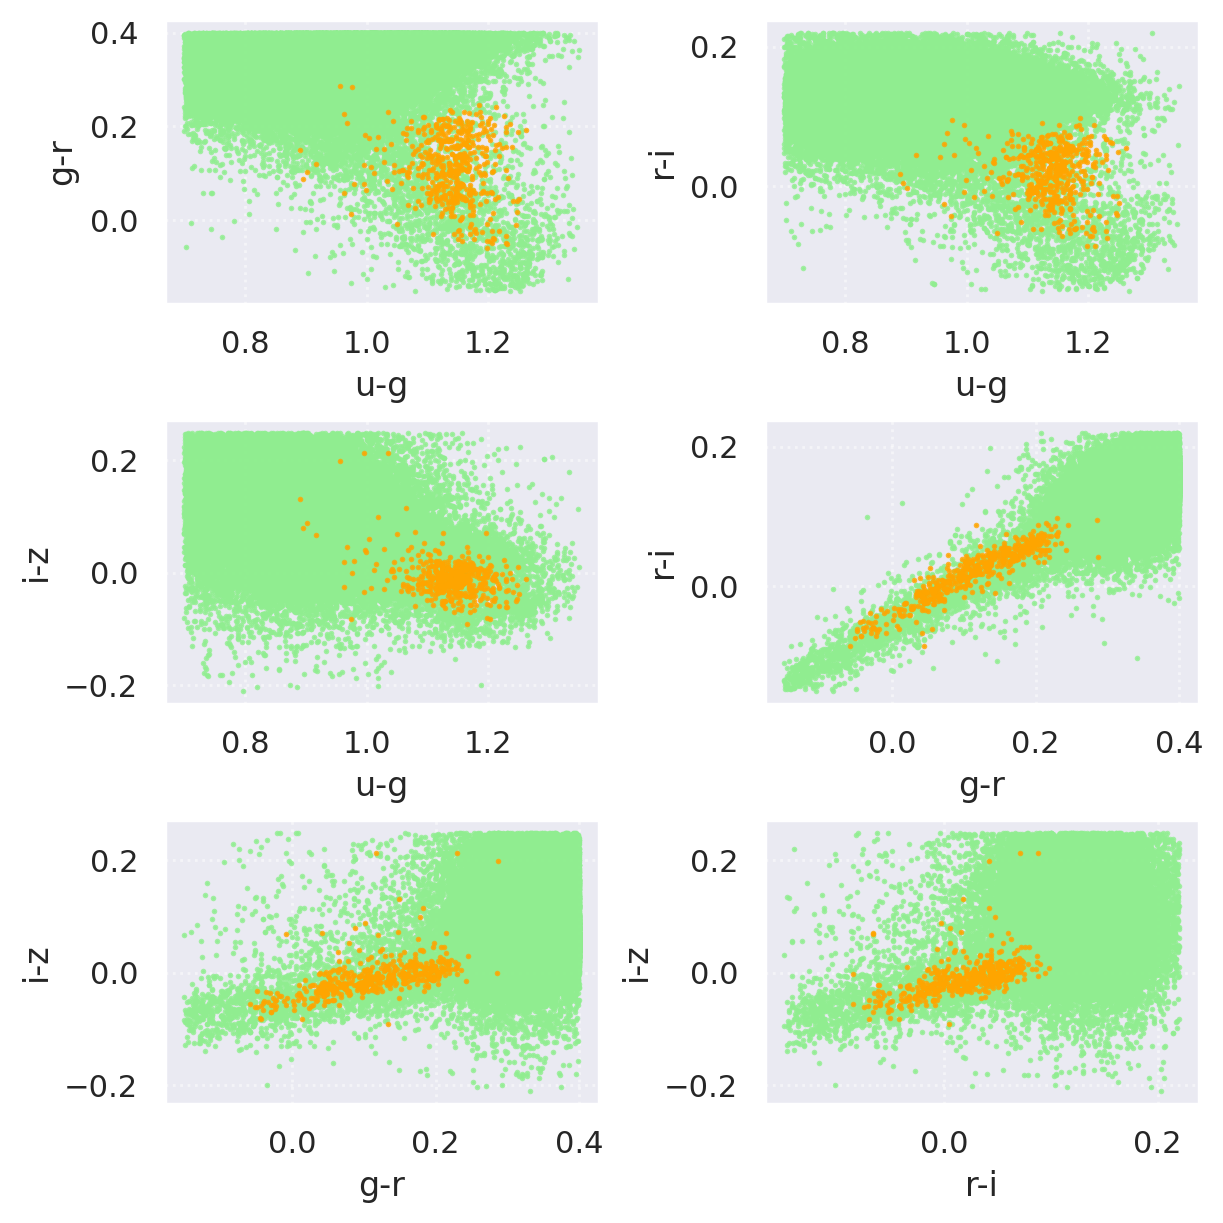

In [3]:
# names of the features, i. e. color magnitudes
features = "u-g g-r r-i i-z".split()

stars = (y == 0)
rrlyrae = (y == 1)

# make six subplots
fig, axes = plt.subplots(3, 2, 
                         figsize=(12/2,6), 
                         dpi=200, 
                        #  sharex="col", 
                        #  sharey="row"
                         constrained_layout=True)

axes = axes.flatten() # 1D array

ax_cnt = 0

for i in range(len(features)):
    for j in range(i+1, len(features)):
        ax = axes[ax_cnt]
        ax.plot(X0[stars, i], X0[stars, j], '.', ms=2,  label='stars',color="lightgreen",alpha=0.8)
        ax.plot(X0[rrlyrae, i], X0[rrlyrae, j], '.', ms=2,  label='RR-Lyrae',color="orange",alpha=0.8)

        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])

        ax.grid(alpha=.5, linestyle=":")
        ax_cnt += 1
        
plt.savefig("all_mags_combs.png")
plt.show()

---
# Exercise 2: Normalizing flow

In [4]:
# command to include the CUDA library for tensorflow, might be needed on some systems
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [5]:
#function to normalize data
def normalize_data(X):
    # Manual Batch Normalization
    all_mean = X.mean(axis=0)
    all_std = X.std(axis=0)
    X = (X - all_mean) / all_std
    return X, all_mean, all_std

In [17]:
#normalize all data for every axis
X, all_mean, all_std = normalize_data(X0)

DATA = np.concatenate((X, y.reshape(y.size, 1)), axis=1)

In [7]:
# maxima/minima of the 4 color magnitudes
maxes = np.max(X, axis=0)
mins = np.min(X, axis=0)

# "up rounded" absolute extrema of all 4 color mag.s
# for [-B, B], see [Durkan et al.]
intervals = np.ceil(np.maximum(np.absolute(maxes), np.absolute(mins))) 

# train, val, test; preserves tensor shape WITH BOTH STARS AND RRLYRAE
data_train_all, data_validate_all, data_test_all = shuffle_split(DATA, 0.8, 0.1) 


2022-09-04 22:33:49.604867: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-04 22:33:49.604924: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (labog): /proc/driver/nvidia/version does not exist
2022-09-04 22:33:49.605727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#determine the probability distribution
f_r = None   #stores the output of the results in the given file
dataset = "stars"  
layer = 4    #number of coupling layers
shape = 64   #number of neurons in the 2 hidden layers
n_bin = 64   #number of bins in one spline

DA_s = DataAnalyse(dataset)

DA_s.prepare_data(BATCH_SIZE = 100, intervals = intervals, data_train_all = data_train_all, data_validate_all = data_validate_all, data_test_all = data_test_all)

DA_s.build_flow(LAYERS = layer, N_BINS = n_bin, SHAPE = [shape,shape], BASE_LR = 0.005)

checkpoint_directory = DA_s.train_model(MAX_EPOCHS = 1000, DELTA_COUNT = 15,f=f_r)

DA_s.test_model(checkpoint_directory = checkpoint_directory,f=f_r)

results = DA_s.summarize_training(f=f_r)

In [8]:
#example of loading a model from a previous checkpoint
prefix = "stars/tmp_8_64_0.005_8"

temp_list = prefix.split("_")
dataset = temp_list[0][:-4]
layer = int(temp_list[1])
shape = int(temp_list[2])
n_bin = int(temp_list[4])

DA_s = DataAnalyse(dataset)

DA_s.prepare_data(BATCH_SIZE = 100, intervals = intervals, data_train_all = data_train_all, data_validate_all = data_validate_all, data_test_all = data_test_all)

DA_s.build_flow(LAYERS = layer, N_BINS = n_bin, SHAPE = [shape,shape], BASE_LR = 0.005)

DA_s.test_model(checkpoint_directory = prefix)

test loss: 4.300123691558838
Test time: 0:0:21.230 h


In [9]:
#example of loading a model from a previous checkpoint
prefix = "rrlyrae/tmp_8_64_0.005_128"

temp_list = prefix.split("_")
dataset = temp_list[0][:-4]
layer = int(temp_list[1])
shape = int(temp_list[2])
n_bin = int(temp_list[4])

DA_r = DataAnalyse(dataset)

DA_r.prepare_data(BATCH_SIZE = 100, intervals = intervals, data_train_all = data_train_all, data_validate_all = data_validate_all, data_test_all = data_test_all)

DA_r.build_flow(LAYERS = layer, N_BINS = n_bin, SHAPE = [shape,shape], BASE_LR = 0.005)

DA_r.test_model(checkpoint_directory = prefix)

test loss: 2.914281129837036
Test time: 0:0:0.232 h


---
# Exercise 3: Classifier

### Define the classifier

In [10]:
from RRlyraeClassifier import rrlyrae_classifier

The Dataset:
Total percentage of positive/real RR Lyrae: 	 0.42%
Total percentage of negative/not RR Lyrae: 	99.58% 

Rate of predictions
	- correct: 	96.84%
	- false pos.: 	 3.16%
	- true pos.: 	 0.42%
	- false neg.: 	 0.00%
	- true neg.: 	96.42%

Percentage of correctly identified 
	- RR Lyrae: 	100.00%
	- non-RR Lyrae:	96.83%


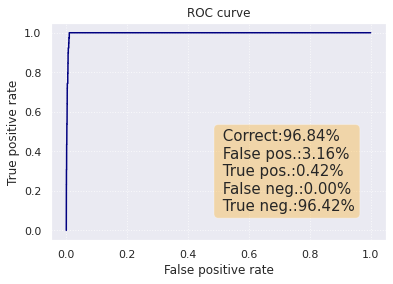

In [11]:
rrlyrae_clf = rrlyrae_classifier(DA_r.flow, DA_s.flow)

rrlyrae_clf.get_test_data(data_test_all)

prediction = rrlyrae_clf.predict()

rrlyrae_clf.evaluate()

rrlyrae_clf.roc_curve("roc_curve.png")

In [12]:
prediction = rrlyrae_clf.predict(activation="logistic")

# Testing 

##### Scatter plots

In [20]:
# names of the features, i. e. color magnitudes
features = "u-g g-r r-i i-z".split()

X, y = fetch_rrlyrae_combined()

stars = (y == 0)
rrlyrae = (y == 1)

# guarantee to have the same proportion of rrlyrae to stars:
smp_stars = DA_s.flow.sample(sample_shape=(stars.sum())).numpy()
smp_rrlyrae = DA_r.flow.sample(sample_shape=(rrlyrae.sum())).numpy()

# reverse the initial manual BatchNorm
smp_stars = (smp_stars * all_std) + all_mean
smp_rrlyrae = (smp_rrlyrae * all_std) + all_mean

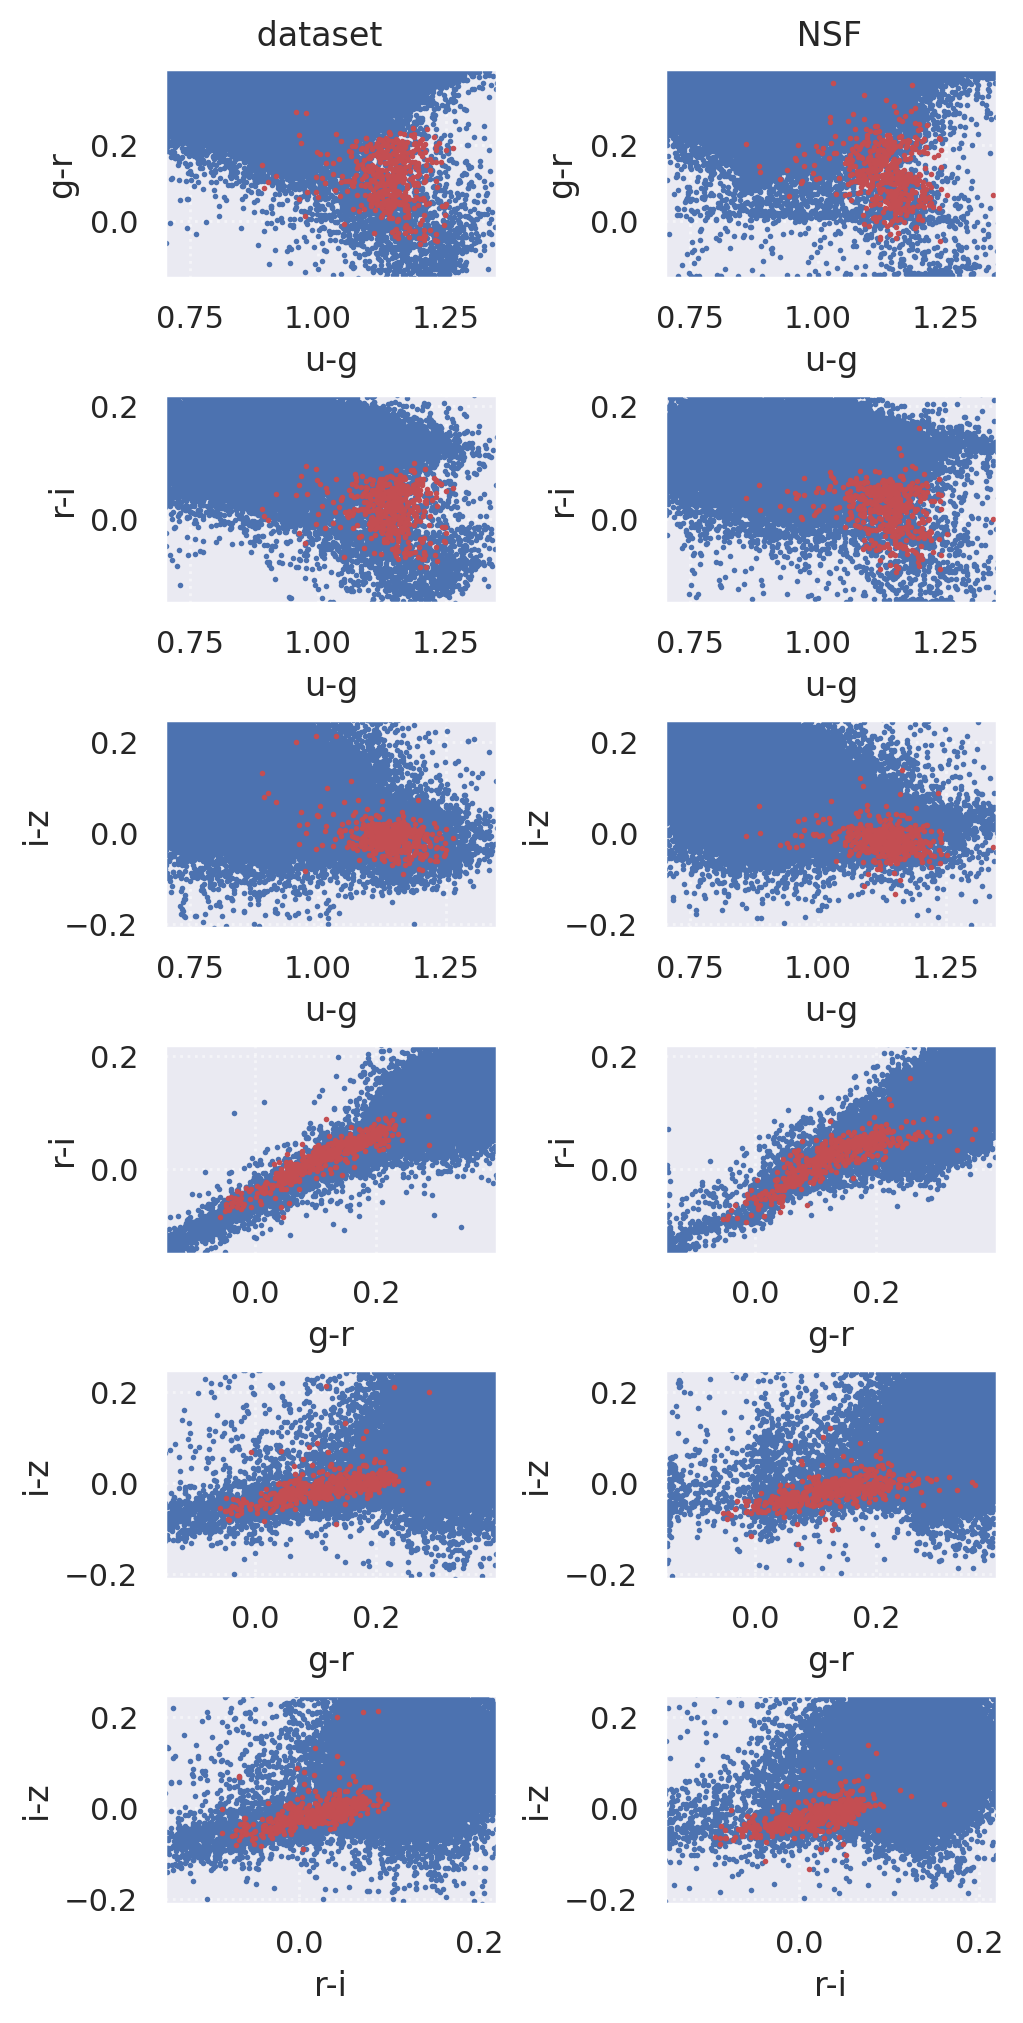

In [26]:
fig, axes = plt.subplots(6, 2, 
                         figsize=(5,10), 
                         dpi=200, 
                         constrained_layout=True)

axes = axes.flatten() # 1D array
ax_cnt = 0

for i in range(len(features)):
    for j in range(i+1, len(features)):
        # REAL DATA
        
        ax = axes[ax_cnt]
        ax.plot(X[stars, i], X[stars, j], '.', ms=2, c='b', label='stars')
        ax.plot(X[rrlyrae, i], X[rrlyrae, j], '.', ms=2, c='r', label='RR-Lyrae')

        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])
        
        ax.set_xlim(X[:, i].min(), X[:, i].max())
        ax.set_ylim(X[:, j].min(), X[:, j].max())

        ax.grid(alpha=.5, linestyle=":")
        ax_cnt += 1
        
        # SAMPLE DATA
        
        ax = axes[ax_cnt]
        ax.plot(smp_stars[:, i], smp_stars[:, j], '.', ms=2, c='b', label='stars')
        ax.plot(smp_rrlyrae[:, i], smp_rrlyrae[:, j], '.', ms=2, c='r', label='RR-Lyrae')

        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])
        
        ax.set_xlim(X[:, i].min(), X[:, i].max())
        ax.set_ylim(X[:, j].min(), X[:, j].max())

        ax.grid(alpha=.5, linestyle=":")
        # ax.legend(loc="upper left")

        ax_cnt += 1
plt.suptitle(f"{9*' '}dataset {37*' '} NSF", ha="center")
plt.savefig("Scatter_plots_comparison.png")
plt.show()

##### Using the Kolmogorov-Smirnov Test like in Exercise 4

In [22]:
from scipy.stats import ks_2samp, kstest, ks_1samp


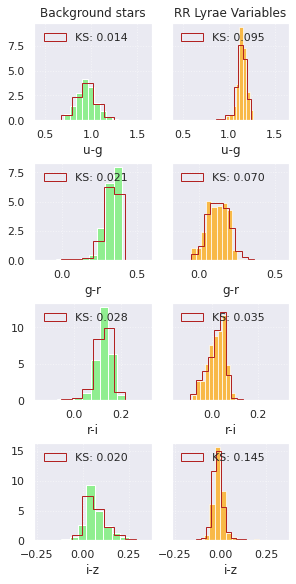

In [23]:
fig, axes = plt.subplots(4, 2, constrained_layout=True, sharex="row", sharey="row", figsize=(4, 8))
axes= axes.flatten()


for i in range(4):
    ax_stars = axes[2*i]
    ax_rrlyrae = axes[2*i+1]
    
    ks_stars = ks_2samp(smp_stars[:, i], X[:, i][stars])[0]
    ks_rrlyrae = ks_2samp(smp_rrlyrae[:, i], X[:, i][rrlyrae])[0]
    
    ax_stars.hist(smp_stars[:, i], histtype="step", color="firebrick", linestyle="-", label=f"KS: {ks_stars:.3f}", density=True)
    ax_stars.hist(X[:, i][stars], color="lightgreen",  density=True)
    
    ax_rrlyrae.hist(smp_rrlyrae[:, i], histtype="step", color="firebrick", linestyle="-", label=f"KS: {ks_rrlyrae:.3f}", density=True)
    ax_rrlyrae.hist(X[:, i][rrlyrae], color="orange",  alpha = 0.7, density=True)
    
    ax_stars.set_xlabel(features[i])
    ax_rrlyrae.set_xlabel(features[i])
    
    ax_stars.legend(loc="upper left", ncol=1, frameon=False)
    ax_rrlyrae.legend(loc="upper left", ncol=1, frameon=False)
    
    ax_stars.grid(ls=":", alpha=.5)
    ax_rrlyrae.grid(ls=":", alpha=.5)

    
axes[0].set_title("Background stars")
axes[1].set_title("RR Lyrae Variables")

fig.savefig("data_comparison.png")
#axes[-2].set_xlabel("color")
#axes[-1].set_xlabel("color")

# Appendix

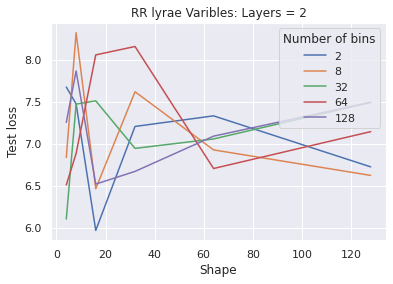

In [37]:
f = open("rrlyrae_allVars.txt","r+")
con = f.readlines()
div_con = []
while(True):
    try:
        ind_stop = con.index('#############################################################\n')
        div_con.append(con[0:ind_stop])
        del con[0:ind_stop+2]
    except ValueError:
        break
    
test_losses = []
layers = []
n_bins= []
shapes = []
for i in range(len(div_con)):
    matches = [match for match in div_con[i] if "Test loss" in match]
    test_losses.append(float(matches[0][11:17]))
    temp_list = div_con[i][1].split(",")
    layer, n_bin, shape = int(temp_list[0][7:]),int(temp_list[1][7:]),int(temp_list[2][7:])
    layers.append(layer)
    n_bins.append(n_bin)
    shapes.append(shape)

import pandas as pd
df = pd.DataFrame({"layer":layers,"n_bin":n_bins,"shape":shapes,"loss":test_losses})
import matplotlib.pyplot as plt
df_t = df[df["n_bin"]==2]
plt.plot(df_t["shape"],df_t["loss"],label="2")
#df_t = df[df["n_bin"]==4]
#plt.plot(df_t["shape"],df_t["loss"],label="4")
df_t = df[df["n_bin"]==8]
plt.plot(df_t["shape"],df_t["loss"],label="8")
#df_t = df[df["n_bin"]==16]
#plt.plot(df_t["shape"],df_t["loss"],label="16")
df_t = df[df["n_bin"]==32]
plt.plot(df_t["shape"],df_t["loss"],label="32")
df_t = df[df["n_bin"]==64]
plt.plot(df_t["shape"],df_t["loss"],label="64")
df_t = df[df["n_bin"]==128]
plt.plot(df_t["shape"],df_t["loss"],label="128")
plt.legend(title="Number of bins")
plt.xlabel("Shape")
plt.ylabel("Test loss")
plt.title("RR lyrae Varibles: Layers = 2")
plt.savefig("rrlyrae_elayer_comp.png")

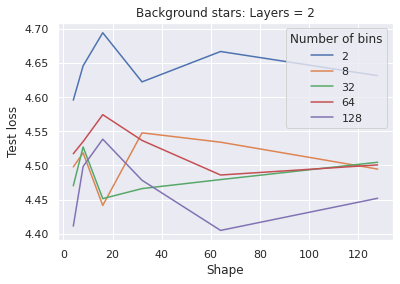

In [38]:
f = open("stars_allVars.txt","r+")
con = f.readlines()
div_con = []
while(True):
    try:
        ind_stop = con.index('#############################################################\n')
        div_con.append(con[0:ind_stop])
        del con[0:ind_stop+2]
    except ValueError:
        break

test_losses = []
layers = []
n_bins= []
shapes = []
for i in range(len(div_con)):
    matches = [match for match in div_con[i] if "Test loss" in match]
    test_losses.append(float(matches[0][11:17]))
    temp_list = div_con[i][1].split(",")
    layer, n_bin, shape = int(temp_list[0][7:]),int(temp_list[1][7:]),int(temp_list[2][7:])
    layers.append(layer)
    n_bins.append(n_bin)
    shapes.append(shape)

import pandas as pd
df = pd.DataFrame({"layer":layers,"n_bin":n_bins,"shape":shapes,"loss":test_losses})
import matplotlib.pyplot as plt
df_t = df[df["n_bin"]==2]
plt.plot(df_t["shape"],df_t["loss"],label="2")
#df_t = df[df["n_bin"]==4]
#plt.plot(df_t["shape"],df_t["loss"],label="4")
df_t = df[df["n_bin"]==8]
plt.plot(df_t["shape"],df_t["loss"],label="8")
#df_t = df[df["n_bin"]==16]
#plt.plot(df_t["shape"],df_t["loss"],label="16")
df_t = df[df["n_bin"]==32]
plt.plot(df_t["shape"],df_t["loss"],label="32")
df_t = df[df["n_bin"]==64]
plt.plot(df_t["shape"],df_t["loss"],label="64")
df_t = df[df["n_bin"]==128]
plt.plot(df_t["shape"],df_t["loss"],label="128")
plt.legend(title="Number of bins")
plt.xlabel("Shape")
plt.ylabel("Test loss")
plt.title("Background stars: Layers = 2")
plt.savefig("stars_2layer_comp.png")